In [217]:
# I import all the needed libraries
import os
import json
import zipfile
import shutil
import random
from pathlib import Path
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K, optimizers
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss, f1_score


import joblib

In [218]:
# I read the dataset and manage it with pandas
filename = "personality_dataset.csv"
df = pd.read_csv(filename)

# I explore the dataset to understand with what am I dealing with
# I check first which values the features have (random take)
df_sample = df.sample(n=10, random_state=42)
print(df_sample)

      Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
141               10.0        Yes                      3.0            3.0   
1557               NaN         No                      NaN            5.0   
485                5.0        Yes                      0.0            0.0   
1712              10.0        Yes                      2.0            2.0   
2250               7.0        Yes                      0.0            0.0   
1457              11.0        Yes                      1.0            1.0   
1133               4.0        Yes                      0.0            0.0   
2711               NaN         No                      4.0            6.0   
554                4.0        Yes                      0.0            1.0   
1993               9.0        Yes                      0.0            2.0   

     Drained_after_socializing  Friends_circle_size  Post_frequency  \
141                        Yes                  5.0             3.0   
1557      

In [219]:
# Then I try to understand the overall dataset look
df.info()
df["Personality"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


,count
Personality,
Extrovert,1491
Introvert,1409


In [220]:
# I notice that I have some non-null values and that there is a type mismatch among the features.

# I try to understand the size and the impact of those missing values.
n_missing_rows = df.isna().any(axis=1).sum()
pct_missing    = 100 * n_missing_rows / len(df)
print(f"Total Rows: {len(df)}, Rows with at least 1 NaN value: {n_missing_rows} ({pct_missing:.1f}%)")
print(df.isna().mean().sort_values(ascending=False) * 100)

Total Rows: 2900, Rows with at least 1 NaN value: 423 (14.6%)
Friends_circle_size          2.655172
Stage_fear                   2.517241
Going_outside                2.275862
Post_frequency               2.241379
Time_spent_Alone             2.172414
Social_event_attendance      2.137931
Drained_after_socializing    1.793103
Personality                  0.000000
dtype: float64


In [221]:
# Since I already have too little datas I decide to not remove the rows with missing values
# but to fill those NaN with the median of the values of the column.
numeric_cols = [
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency",
]

for col in numeric_cols:
    med = df[col].median()
    df[col].fillna(med, inplace=True)

<ipython-input-221-27de9019dbd3>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(med, inplace=True)


In [222]:
# For those features which are actually objects, I will fill with the trend (mode).
cat_yesno = ["Stage_fear", "Drained_after_socializing"]
for col in cat_yesno:
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = df[col].map({"No": 1.0, "Yes": 0.0})

df["Personality"] = df["Personality"].map({"Introvert": 0.0, "Extrovert": 1.0})

# Notice that by putting No = 1, Yes = 0 and then Introvert = 0 and Extrovert = 1
# I am trying to align everything to have a meaning.

# Final check to ensure everything worked right
print(df.isna().sum())
print(df.info())

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   float64
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   float64
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   float64
dtypes: float64(8)
memory usage: 181.4 KB
None


<ipython-input-222-333528254cc0>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-222-333528254cc0>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

       Time_spent_Alone   Stage_fear  Social_event_attendance  Going_outside  \
count       2900.000000  2900.000000              2900.000000    2900.000000   
mean           4.494828     0.513793                 3.942759       3.000000   
std            3.441971     0.499896                 2.875987       2.221597   
min            0.000000     0.000000                 0.000000       0.000000   
25%            2.000000     0.000000                 2.000000       1.000000   
50%            4.000000     1.000000                 3.000000       3.000000   
75%            7.000000     1.000000                 6.000000       5.000000   
max           11.000000     1.000000                10.000000       7.000000   

       Drained_after_socializing  Friends_circle_size  Post_frequency  \
count                2900.000000          2900.000000     2900.000000   
mean                    0.514828             6.235172        3.552069   
std                     0.499866             4.237255       

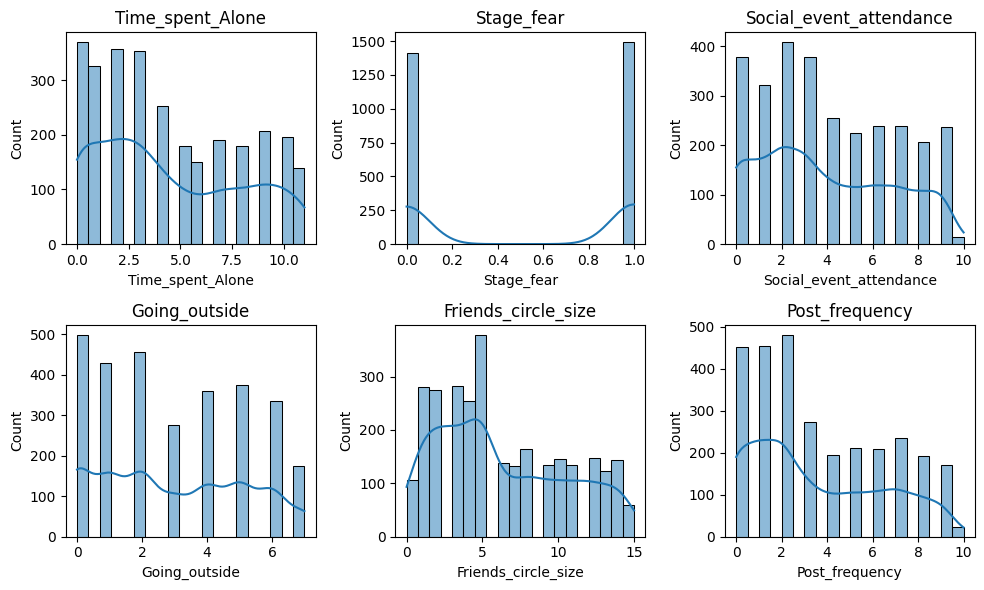

In [223]:
# I print statistical metrics for all the features (mean, std, ecc.)
print(df.describe())

# I print istograms as well to see them visually
numeric_cols = [
    "Time_spent_Alone",
    "Stage_fear",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency"
]

plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


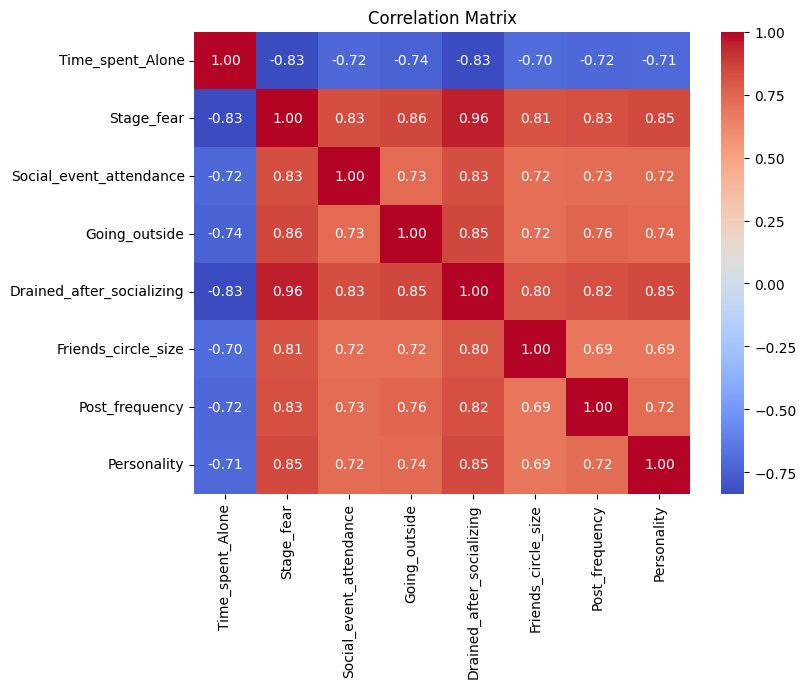

In [224]:
# I calculate and print the correlation matrix among all the features
corr = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [225]:
# I drop the columns of "Personality" because that's the output we wanna get
X = df.drop(columns="Personality")
y = df["Personality"]

# I split the dataset in 20% test - 20% validation and 60% training
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# (taking 25% of 80% is like taking 20% of 100%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_trainval
)

print(f"Shape Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}\n")
print("Output distribution (Train):\n", y_train.value_counts(normalize=True))
print("Output distribution (Val):\n",   y_val.value_counts(normalize=True))
print("Output distribution (Test):\n",  y_test.value_counts(normalize=True))

# I scale using standard scaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)



Shape Train: (1740, 7), Val: (580, 7), Test: (580, 7)

Output distribution (Train):
 Personality
1.0    0.514368
0.0    0.485632
Name: proportion, dtype: float64
Output distribution (Val):
 Personality
1.0    0.513793
0.0    0.486207
Name: proportion, dtype: float64
Output distribution (Test):
 Personality
1.0    0.513793
0.0    0.486207
Name: proportion, dtype: float64


In [226]:
# I use lasso regression as a feature selector to understand if I can neglect
# some features since the correlation matrix had high values.
l1_lr = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10],
    penalty="l1",
    solver="saga",
    cv=5,
    scoring="f1",
    class_weight="balanced",
    random_state=42,
    max_iter=5000
)

l1_lr.fit(X_train_scaled, y_train)
print("Coefficient for every feature:\n",
      pd.Series(l1_lr.coef_.flatten(), index=X_train.columns))

Coefficient for every feature:
 Time_spent_Alone             0.000000
Stage_fear                   1.212306
Social_event_attendance      0.024348
Going_outside                0.000000
Drained_after_socializing    1.128209
Friends_circle_size          0.000000
Post_frequency               0.161040
dtype: float64


In [227]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_val)
f1_dummy = f1_score(y_val, y_pred_dummy)
print("Dummy F1 =", f1_dummy)

Dummy F1 = 0.6788154897494305


In [228]:
def train_and_evaluate_logistic(X_tr, y_tr, X_va, y_va):
    model = LogisticRegression(
        class_weight="balanced",
        random_state=42,
        max_iter=1000
    )
    model.fit(X_tr, y_tr)

    y_va_pred = model.predict(X_va)

    acc = accuracy_score(y_va, y_va_pred)
    f1 = f1_score(y_va, y_va_pred)
    report = classification_report(y_va, y_va_pred, target_names=["Introvert","Extrovert"])

    return {
        "model": model,
        "accuracy": acc,
        "f1_score": f1,
        "class_report": report
    }

all_features = [
    "Time_spent_Alone",
    "Stage_fear",
    "Social_event_attendance",
    "Going_outside",
    "Drained_after_socializing",
    "Friends_circle_size",
    "Post_frequency"
]

# (B) I remove the features “Going_outside", “Friends_circle_size” and "Time_spent_Alone"
features_minus_three = [
    "Stage_fear",
    "Social_event_attendance",
    "Drained_after_socializing",
    "Post_frequency"
]

# (C) I remove the features “Going_outside” and “Friends_circle_size”
features_minus_two = [
    "Time_spent_Alone",
    "Stage_fear",
    "Social_event_attendance",
    "Drained_after_socializing",
    "Post_frequency"
]

# (D) I remove only “Going_outside”
features_minus_one = [
    "Time_spent_Alone",
    "Stage_fear",
    "Social_event_attendance",
    "Drained_after_socializing",
    "Friends_circle_size",
    "Post_frequency"
]

# I train every model on validation
experiments = [
    ("Model A (all the features)", all_features),
    ("Model B (no Going_outside, no Friends_circle_size, no Time_spent_Alone)", features_minus_three),
    ("Model C (no Going_outside, no Friends_circle_size)", features_minus_two),
    ("Model D (no Going_outside)", features_minus_one),
]

results = {}

for name, feat_list in experiments:
    print(f"\n=== {name} ===")
    X_tr_sub = X_train_scaled[feat_list]
    X_va_sub = X_val_scaled[feat_list]

    res = train_and_evaluate_logistic(X_tr_sub, y_train, X_va_sub, y_val)
    results[name] = res

    # Metrics
    print(f"Accuracy (validation):  {res['accuracy']:.4f}")
    print(f"f1_score  (validation):  {res['f1_score']:.4f}")
    print("Classification Report (validation):")
    print(res["class_report"])

    # Confusion matrix
    y_va_pred = res["model"].predict(X_va_sub)
    cm = confusion_matrix(y_val, y_va_pred)
    print("Confusion Matrix (validation):")
    print(pd.DataFrame(
        cm,
        index=["Real Introvert", "Real Extrovert"],
        columns=["Predicted Introvert", "Predicted Extrovert"]
    ))

# Full summary on validation
print("\n=== Summary of accuracies and F1 on validation ===")
for name, res in results.items():
    print(f"{name:75s} | Acc: {res['accuracy']:.4f} | F1_score: {res['f1_score']:.4f}")


=== Model A (all the features) ===
Accuracy (validation):  0.9414
f1_score  (validation):  0.9433
Classification Report (validation):
              precision    recall  f1-score   support

   Introvert       0.95      0.93      0.94       282
   Extrovert       0.94      0.95      0.94       298

    accuracy                           0.94       580
   macro avg       0.94      0.94      0.94       580
weighted avg       0.94      0.94      0.94       580

Confusion Matrix (validation):
                Predicted Introvert  Predicted Extrovert
Real Introvert                  263                   19
Real Extrovert                   15                  283

=== Model B (no Going_outside, no Friends_circle_size, no Time_spent_Alone) ===
Accuracy (validation):  0.9552
f1_score  (validation):  0.9561
Classification Report (validation):
              precision    recall  f1-score   support

   Introvert       0.95      0.96      0.95       282
   Extrovert       0.96      0.95      0.96    

In [229]:
# I'll train with a different split
X_train2, X_temp, y_train2, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)
X_val2, X_test2, y_val2, y_test2 = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Shapes 70/15/15 →",
      f"Train: {X_train2.shape},",
      f"Val:   {X_val2.shape},",
      f"Test:  {X_test2.shape}")

print("\nClass balance (Train):\n", y_train2.value_counts(normalize=True))
print("\nClass balance (Val):\n",   y_val2.value_counts(normalize=True))
print("\nClass balance (Test):\n",  y_test2.value_counts(normalize=True))



Shapes 70/15/15 → Train: (2030, 7), Val:   (435, 7), Test:  (435, 7)

Class balance (Train):
 Personality
1.0    0.514286
0.0    0.485714
Name: proportion, dtype: float64

Class balance (Val):
 Personality
1.0    0.514943
0.0    0.485057
Name: proportion, dtype: float64

Class balance (Test):
 Personality
1.0    0.512644
0.0    0.487356
Name: proportion, dtype: float64


In [230]:
features_B = [
    "Stage_fear",
    "Social_event_attendance",
    "Drained_after_socializing",
    "Post_frequency"
]

scaler2 = StandardScaler()
scaler2.fit(X_train2)

X_train2_scaled = pd.DataFrame(
    scaler2.transform(X_train2),
    columns=X_train2.columns, index=X_train2.index
)
X_val2_scaled = pd.DataFrame(
    scaler2.transform(X_val2),
    columns=X_val2.columns, index=X_val2.index
)
X_test2_scaled = pd.DataFrame(
    scaler2.transform(X_test2),
    columns=X_test2.columns, index=X_test2.index
)

def fit_logistic(X_tr, y_tr, X_va, y_va):
    lr = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
    lr.fit(X_tr, y_tr)
    y_va_pred = lr.predict(X_va)
    y_va_proba = lr.predict_proba(X_va)[:,1]
    return {
        "model": lr,
        "acc": accuracy_score(y_va, y_va_pred),
        "f1_score": f1_score(y_va, y_va_pred),
        "report": classification_report(y_va, y_va_pred, target_names=["Introvert","Extrovert"])
    }

res_B_split2 = fit_logistic(
    X_train2_scaled[features_B], y_train2,
    X_val2_scaled[features_B],   y_val2
)
print("Model B split2 – Accuracy:", res_B_split2["acc"])
print("Model B split2 – F1_score:", res_B_split2["f1_score"])
print("Classification Report:\n", res_B_split2["report"])


Model B split2 – Accuracy: 0.9425287356321839
Model B split2 – F1_score: 0.9433106575963719
Classification Report:
               precision    recall  f1-score   support

   Introvert       0.93      0.96      0.94       211
   Extrovert       0.96      0.93      0.94       224

    accuracy                           0.94       435
   macro avg       0.94      0.94      0.94       435
weighted avg       0.94      0.94      0.94       435



Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 — train_f1: 0.6692   val_f1: 0.6827
28/28 - 1s - 44ms/step - accuracy: 0.4939 - loss: 0.7129 - val_accuracy: 0.5224 - val_loss: 0.6655 - train_f1: 0.6692 - val_f1: 0.6827
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 — train_f1: 0.9192   val_f1: 0.9465
28/28 - 0s - 10ms/step - accuracy: 0.6229 - loss: 0.6404 - val_accuracy: 0.9448 - val_loss: 0.5947 - train_f1: 0.9192 - val_f1: 0.9465
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 — train_f1: 0.9239   val_f1: 0.9513
28/28 - 0s - 13ms/step - accuracy: 0.9212 - loss: 0.5771 - val_accuracy: 0.9500 - val_loss: 0.5312 - train_f1: 0.9239 - val_f1: 0.9513
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 — train_f1: 0.9259   val_f1: 0.9513
28/28 - 0s - 11ms/step - accuracy: 0.9251 - loss: 0.5208 - val_accuracy: 0.9500

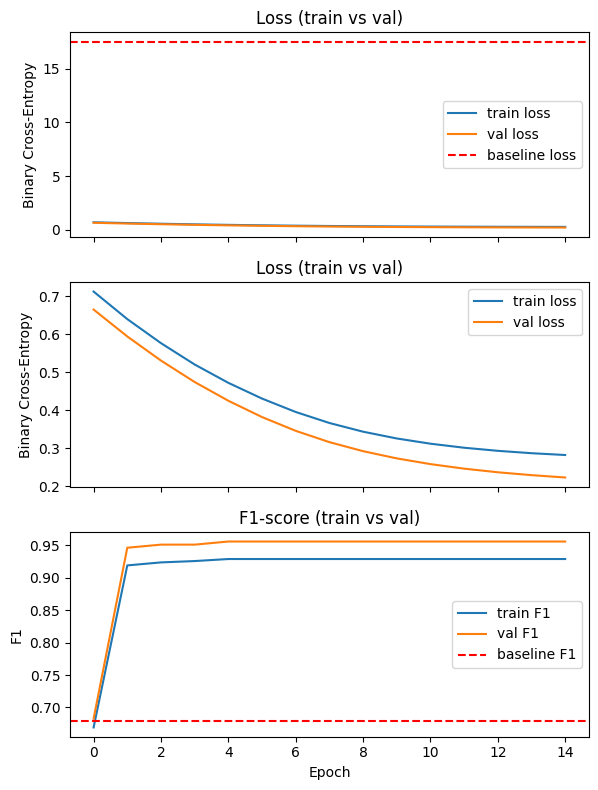

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Best VAL F1 = 0.9561 at thr = 0.50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== FINAL TEST EVAL ===
Accuracy: 0.9224137931034483
F1-score: 0.9235993208828522
              precision    recall  f1-score   support

   Introvert       0.91      0.93      0.92       282
   Extrovert       0.93      0.91      0.92       298

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Confusion Matrix:
          Pred Int  Pred Ext
Real Int       263        19
Real Ext        26       272


In [231]:
# I create F1-metric callback
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, batch_size=256):
        super().__init__()
        self.X_train, self.y_train = X_train, y_train
        self.X_val,   self.y_val   = X_val,   y_val
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        # predict train
        y_tr_proba = self.model.predict(self.X_train, batch_size=self.batch_size)
        y_tr_pred  = (y_tr_proba.ravel() >= 0.5).astype(int)
        tr_f1 = f1_score(self.y_train, y_tr_pred)
        # predict val
        y_val_proba = self.model.predict(self.X_val, batch_size=self.batch_size)
        y_val_pred  = (y_val_proba.ravel() >= 0.5).astype(int)
        val_f1 = f1_score(self.y_val, y_val_pred)
        logs = logs or {}
        logs["train_f1"], logs["val_f1"] = tr_f1, val_f1
        print(f" — train_f1: {tr_f1:.4f}   val_f1: {val_f1:.4f}")

# I prepare the datas to be managed by keras
X_tr_nn = X_train_scaled[features_B].values
X_va_nn = X_val_scaled[features_B].values
X_te_nn = X_test_scaled[features_B].values

y_tr_nn = y_train.values
y_va_nn = y_val.values
y_te_nn = y_test.values

# I consider the slight classes unbalance
cw_vals = compute_class_weight("balanced", classes=np.unique(y_tr_nn), y=y_tr_nn)
cw = dict(enumerate(cw_vals))

# oversample
ros = RandomOverSampler(random_state=42)
X_tr_os, y_tr_os = ros.fit_resample(X_tr_nn, y_tr_nn)

# I Build and compile model
tf.random.set_seed(42)
model_nn = models.Sequential([
    layers.Input(shape=(len(features_B),)),
    layers.Dense(128, activation="relu"),
    layers.Dense(32,  activation="relu"),
    layers.Dense(1,   activation="sigmoid")
])

model_nn.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# I set the callbacks
f1_cb = F1Metrics(X_tr_os, y_tr_os, X_va_nn, y_va_nn, batch_size=64)
es    = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1", mode="max",
    patience=10, restore_best_weights=True, verbose=1
)

# I train
history = model_nn.fit(
    X_tr_os, y_tr_os,
    validation_data=(X_va_nn, y_va_nn),
    epochs=100, batch_size=64,
    class_weight=cw,
    callbacks=[f1_cb, es],
    verbose=2
)

# I compute dummy baselines
dum = DummyClassifier(strategy="most_frequent")
dum.fit(X_tr_nn, y_tr_nn)
# baseline F1
y_va_dum = dum.predict(X_va_nn)
baseline_f1  = f1_score(y_va_nn, y_va_dum)
# baseline loss
y_va_dum_proba = dum.predict_proba(X_va_nn)[:,1]
baseline_loss   = log_loss(y_va_nn, y_va_dum_proba)
print(f"\nBaseline F1 on VAL:   {baseline_f1:.4f}")
print(f"Baseline Loss on VAL: {baseline_loss:.4f}\n")

# Final plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

# Panel 1: Loss (train vs val) + baseline loss
ax = axes[0]
ax.plot(history.history["loss"],     label="train loss")
ax.plot(history.history["val_loss"], label="val loss")
ax.axhline(baseline_loss, color="red", linestyle="--", label="baseline loss")
ax.set_title("Loss (train vs val)")
ax.set_ylabel("Binary Cross‐Entropy")
ax.legend()

# Panel 2: Loss (train vs val)
ax = axes[1]
ax.plot(history.history["loss"],     label="train loss")
ax.plot(history.history["val_loss"], label="val loss")
ax.set_title("Loss (train vs val)")
ax.set_ylabel("Binary Cross‐Entropy")
ax.legend()

# Panel 3: F1‐score (train vs val) + baseline F1
ax = axes[2]
ax.plot(history.history["train_f1"], label="train F1")
ax.plot(history.history["val_f1"],   label="val F1")
ax.axhline(baseline_f1, color="red", linestyle="--", label="baseline F1")
ax.set_title("F1‐score (train vs val)")
ax.set_xlabel("Epoch")
ax.set_ylabel("F1")
ax.legend()

plt.tight_layout()
plt.show()

# Final evaluations
probs_va = model_nn.predict(X_va_nn).ravel()
best_f1, best_t = 0, 0.5
for t in np.linspace(0.1, 0.9, 81):
    f = f1_score(y_va_nn, (probs_va >= t).astype(int))
    if f > best_f1:
        best_f1, best_t = f, t
print(f"Best VAL F1 = {best_f1:.4f} at thr = {best_t:.2f}")

probs_te = model_nn.predict(X_te_nn).ravel()
y_te_pred = (probs_te >= best_t).astype(int)
print("\n=== FINAL TEST EVAL ===")
print("Accuracy:", accuracy_score(y_te_nn, y_te_pred))
print("F1-score:", f1_score(y_te_nn, y_te_pred))
print(classification_report(y_te_nn, y_te_pred, target_names=["Introvert","Extrovert"]))
print("Confusion Matrix:")
print(pd.DataFrame(
    confusion_matrix(y_te_nn, y_te_pred),
    index=["Real Int","Real Ext"],
    columns=["Pred Int","Pred Ext"]
))


In [232]:
# I try 5-fold cross-validation
scaler = StandardScaler().fit(X[features_B])
X_scaled = scaler.transform(X[features_B])
y_array = y.values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)

cv_results = cross_validate(
    lr,
    X_scaled,
    y_array,
    cv=skf,
    scoring=["accuracy","f1"],
    return_train_score=False,
    n_jobs=-1
)

# I Pull out the per-fold scores
acc_scores = cv_results["test_accuracy"]
f1_scores  = cv_results["test_f1"]

# I print the summary
print("Accuracy per fold :", np.round(acc_scores, 4))
print("Accuracy mean/std :", f"{acc_scores.mean():.4f} ± {acc_scores.std():.4f}\n")

print("F1-score per fold :", np.round(f1_scores, 4))
print("F1-score mean/std :", f"{f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

Accuracy per fold : [0.9293 0.9172 0.9207 0.9241 0.95  ]
Accuracy mean/std : 0.9283 ± 0.0116

F1-score per fold : [0.9309 0.9186 0.922  0.9262 0.9516]
F1-score mean/std : 0.9299 ± 0.0116


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth":    [3, 5, 7],
    "min_samples_leaf": [1, 2, 5]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train[features_B], y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best CV F1 :", grid_rf.best_score_)

# Evaluate best RF on validation
best_rf = grid_rf.best_estimator_
y_val_pred_best = best_rf.predict(X_val[features_B])
print("Tuned RF (validation) F1:", f1_score(y_val, y_val_pred_best))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
